# 0. 掛載雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/MyDrive/cifar10.zip" -d "/content/sample_data/"

# 1. 載入需要的 Module

In [ ]:
# pytorch 相關
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from torchvision import models
# 其他
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import copy
import os

In [ ]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# 2. 設置超參數

In [ ]:
lr = 0.0001
batch_size = 512
epochs = 100
model_path = '/content/sample_data/model.pth'
train_path = '/content/sample_data/cifar10/cifar10/train'
test_path = '/content/sample_data/cifar10/cifar10/test'

# 3. 數據預處理

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# 4. 載入 Dataset

In [ ]:
class Cifar10(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.classes = os.listdir(root_dir)
    self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
    self.images = self.load_images()

  def get_classes(self):
    return self.classes

  def load_images(self):
    images = []
    for cls_name in self.classes:
        cls_dir = os.path.join(self.root_dir, cls_name)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            images.append((img_path, self.class_to_idx[cls_name]))
    return images

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path, label = self.images[idx]
    img = Image.open(img_path).convert('RGB')
    if self.transform:
        img = self.transform(img)
    return img, label

In [ ]:
train_dataset = Cifar10(train_path,train_transform)
test_dataset = Cifar10(test_path,test_transform)

In [ ]:
classes = train_dataset.get_classes()
print(classes)

['frog', 'cat', 'ship', 'automobile', 'horse', 'deer', 'dog', 'airplane', 'truck', 'bird']


# 5. 載入 Dataloader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True,num_workers=2)

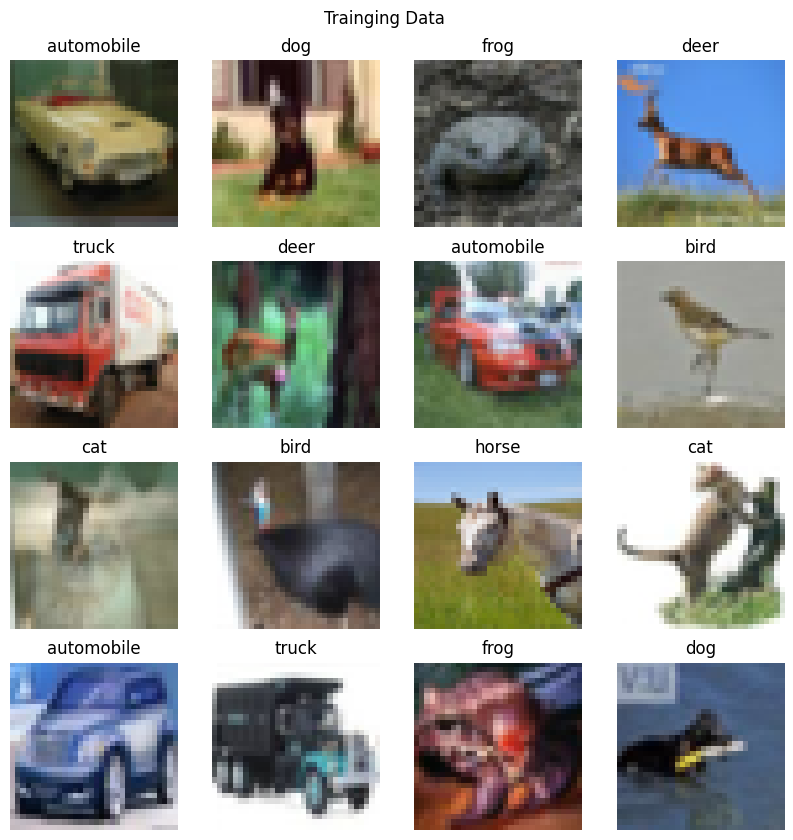

In [ ]:
data_iterator = iter(train_loader)

inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i]
    #  (channels, height, width) in PyTorch => (height, width, channels)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = classes[labels[i]]
    plt.title(title)
    plt.axis('off')
plt.suptitle(f'Trainging Data', y=0.93)

plt.show()

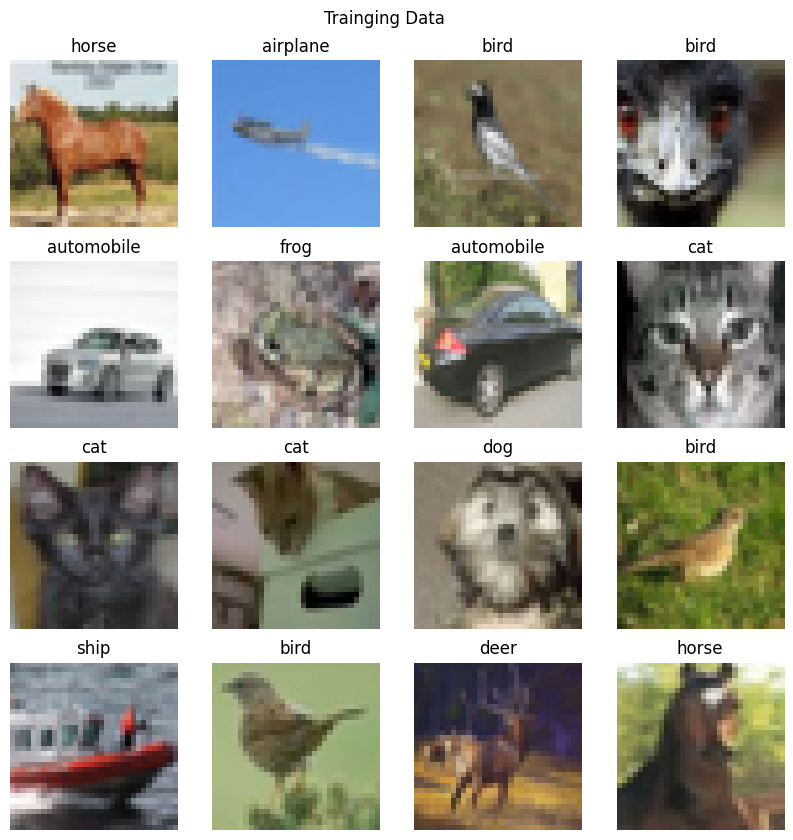

In [ ]:
data_iterator = iter(test_loader)

inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i]
    #  (channels, height, width) in PyTorch => (height, width, channels)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = classes[labels[i]]
    plt.title(title)

    plt.axis('off')
plt.suptitle(f'Trainging Data', y=0.93)

plt.show()

# 6. 定義模型

In [ ]:
model = models.vgg16(weights='DEFAULT')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_fcin = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_fcin, len(classes))
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 7. 定義 Cost function

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

# 8. 開始訓練

In [ ]:
# best model accurancy
best_acc = 0.0
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):

  train_epoch_loss = 0.0

  train_class_correct = list(0. for i in range(len(classes)))
  train_class_total = list(0. for i in range(len(classes)))

  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    # Compute Loss & Update Weight
    batch_loss = loss(outputs, labels)
    batch_loss.backward()
    optimizer.step()

    train_epoch_loss += batch_loss.item()

    # Compute train_class_correct of each batch
    _, predicted = torch.max(outputs, 1)
    batch_correct = (predicted == labels)
    for j in range(len(labels)):
      label = labels[j]
      train_class_correct[label] += batch_correct[j].item()
      train_class_total[label] += 1

  # Compute Loss & Acc
  train_epoch_loss = train_epoch_loss / len(train_loader)
  train_epoch_accurncy = sum(train_class_correct) / sum(train_class_total) * 100

  train_loss.append(train_epoch_loss)
  train_acc.append(train_epoch_accurncy)

  print('[Epoch:%2d]' % (epoch + 1))
  print('Train Accuracy of All : %.3f %%' % (train_epoch_accurncy))
  print('Train Loss of All : %.3f ' % (train_epoch_loss))
  print("----------------------------------------")

  # Validation class correct & class total
  val_loss = 0.0
  val_class_correct = list(0. for i in range(len(classes)))
  val_class_total = list(0. for i in range(len(classes)))

  # Validation every epoch
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)

      # 1. Compute val_batch_loss
      batch_loss = loss(outputs, labels)
      val_loss += batch_loss.item()

      # 2. Compute val_class_correct of each batch
      _, predicted = torch.max(outputs, 1)
      batch_correct = (predicted == labels)
      for j in range(len(labels)):
        label = labels[j]
        val_class_correct[label] += batch_correct[j].item()
        val_class_total[label] += 1
  # print each class accurancy of Validation
  for i in range(len(classes)):
    label = classes[i]
    print('Accuracy of %5s : %2d %%' % (label, 100 * val_class_correct[i] / val_class_total[i]))
  # Compute Loss & Acc of Validation
  val_accurncy = sum(val_class_correct) / sum(val_class_total) * 100
  val_loss = val_loss / len(test_loader)

  test_loss.append(val_loss)
  test_acc.append(val_accurncy)

  print('Validation Accuracy of All : %.3f %%' % (val_accurncy))
  print('Validation Loss of All : %.3f ' % (val_loss))
  print("----------------------------------------")

  # Save best model
  if val_accurncy > best_acc:
    best_acc = val_accurncy
    torch.save(model.state_dict(), model_path)
print('Finished Training')

[Epoch: 1]
Train Accuracy of All : 25.602 %
Train Loss of All : 2.075 
----------------------------------------
Accuracy of  frog : 50 %
Accuracy of   cat : 29 %
Accuracy of  ship : 40 %
Accuracy of automobile : 47 %
Accuracy of horse : 42 %
Accuracy of  deer : 40 %
Accuracy of   dog : 37 %
Accuracy of airplane : 41 %
Accuracy of truck : 56 %
Accuracy of  bird : 18 %
Validation Accuracy of All : 40.440 %
Validation Loss of All : 1.705 
----------------------------------------
[Epoch: 2]
Train Accuracy of All : 46.252 %
Train Loss of All : 1.516 
----------------------------------------
Accuracy of  frog : 57 %
Accuracy of   cat : 35 %
Accuracy of  ship : 53 %
Accuracy of automobile : 62 %
Accuracy of horse : 58 %
Accuracy of  deer : 44 %
Accuracy of   dog : 48 %
Accuracy of airplane : 53 %
Accuracy of truck : 63 %
Accuracy of  bird : 31 %
Validation Accuracy of All : 50.840 %
Validation Loss of All : 1.384 
----------------------------------------
[Epoch: 3]
Train Accuracy of All : 53.

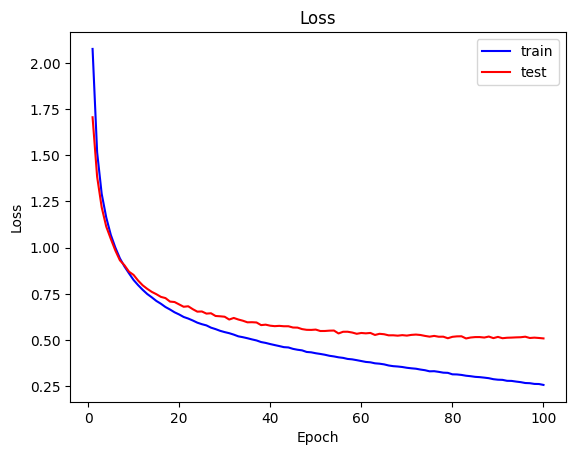

In [ ]:
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(i+1 for i in range(epochs)),train_loss, 'b')
plt.plot(list(i+1 for i in range(epochs)),test_loss, 'r')
plt.legend(['train','test'])
plt.show()

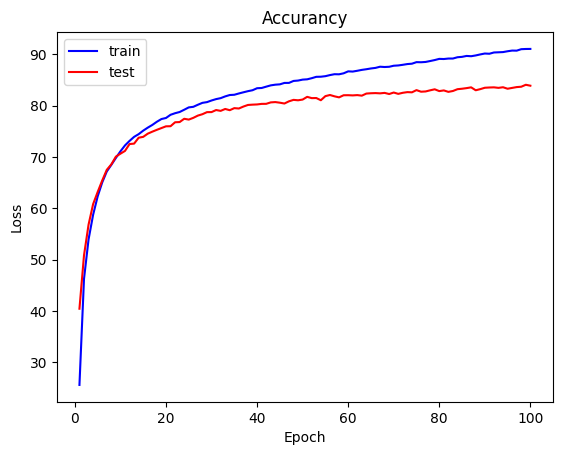

In [ ]:
plt.title("Accurancy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(i+1 for i in range(epochs)),train_acc, 'b')
plt.plot(list(i+1 for i in range(epochs)),test_acc, 'r')
plt.legend(['train','test'])
plt.show()